# Multi-Modal Learning by Late Fusion Technique


A multi-modal system is more robust and accurate in terms on predictions and taking actions based on these predictions. For an AI system to be more <i>"human-like"</i> a fusion of multiple modalities is extremely important as human experience of the world is a fusion of multiple modalities – like vision, text interpretation, audio interpretation etc.

In this workshop, we will target on the late fusion technique of multi-modal learning for the purpose of person identification using image and speech data. 

<img src="Notebook Images/Late Fusion.PNG">

In [1]:
# Importing the packages
from packages import *
%matplotlib inline

Using TensorFlow backend.
D:\Users\Aditya Bhattacharya\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Modality 1 : Subject identification using computer vision

Face recognition identifies persons on face images or video frames. This notebook uses a deep convolutional neural network (CNN) to extract features from input images. 
After an overview of the CNN architecure and how the model can be trained, it is demonstrated how to:
<li>Detect, transform, and crop faces on input images. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.
<li>Use the CNN to extract 128-dimensional representations, or embeddings, of faces from the aligned input images. In embedding space, Euclidean distance directly corresponds to a measure of face similarity.
<li>Compare input embedding vectors to labeled embedding vectors in a database. Here, a support vector machine (SVM) and a KNN classifier, trained on labeled embedding vectors, play the role of a database. Face recognition in this context means using these classifiers to predict the labels i.e. identities of new inputs.
<img src="Notebook Images/Siamese Network.PNG">

Face recognition model architecture used: A variant of the NN4 architecture described in [[1]](https://arxiv.org/abs/1503.03832) and identified as [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) model in the OpenFace project. 

In [2]:
# Load model

nn4_small2 = create_model()

# Pre-trained model:

nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')


# Positive and Negative cases

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# Load Image Data
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #img = img[...,::-1]
    return img

# Loading the image meta-data
metadata = load_metadata('data/images')

# Initialize the OpenFace face alignment utility
from align import AlignDlib
alignment = AlignDlib('models/landmarks.dat')

### Load the image data and looking at the data

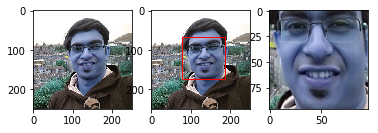

In [6]:
# Load an image 
jc_orig = load_image(metadata[6].image_path())
plt.imshow(jc_orig)

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)


# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned)

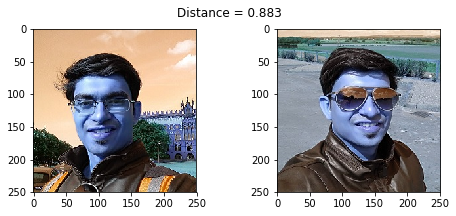

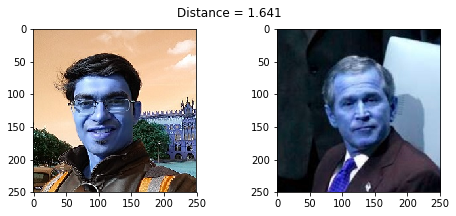

In [7]:
# Train with image dat
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distance = {0:.3f}'.format(distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(7, 8)
show_pair(7, 57)

<img src="Notebook Images/Face Verification.PNG">

In [ ]:
# Model accuracy
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {0:.2f} = {1:.3f}'.format(opt_tau,opt_acc));
plt.xlabel('Distance threshold')
plt.legend();



In [ ]:

# Classification

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0:.2f}, SVM accuracy = {1:.2f}'.format(acc_knn,acc_svc))

warnings.filterwarnings('ignore')

example_idx = 5

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title('Recognized as {0}'.format(example_identity));

## Modality 2: Subject recognition using audio

For the second part, we will implement an algorithm for wake-on word detection. Wake-on word or trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri to wake up upon hearing a certain word.

<img src="Notebook Images/Wake-On Word Detection.PNG">

For this exercise, our trigger word will be "Activate" Every time it hears you say "Activate" it will make a sound. If you want to create your own key-pharse, please refer the notebook: "train_your_own_wakeon_word"


<img src="Notebook Images/must.gif">

In [2]:
# Build the model

# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

# Use 1101 for 2sec input audio
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

# Use 272 for 2sec input audio
Ty = 1375# The number of time steps in the output of our model

model = model(input_shape = (Tx, n_freq))
# model.summary()

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

model = load_model('./models/tr_model.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


D:\Users\Aditya Bhattacharya\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
# Load Audio Data

def detect_triggerword_spectrum(x):
    """
    Function to predict the location of the trigger word.
    
    Argument:
    x -- spectrum of shape (freqs, Tx)
    i.e. (Number of frequencies, The number time steps)

    Returns:
    predictions -- flattened numpy array to shape (number of output time steps)
    """
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.5):
    """
    Function to detect new trigger word in the latest chunk of input audio.
    It is looking for the rising edge of the predictions data belongs to the
    last/latest chunk.
    
    Argument:
    predictions -- predicted labels from model
    chunk_duration -- time in second of a chunk
    feed_duration -- time in second of the input to model
    threshold -- threshold for probability above a certain to be considered positive

    Returns:
    True if new trigger word detected in the latest chunk
    """
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False
    
chunk_duration = 2 # Each read length in seconds from mic.
fs = 44100 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 10
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

def get_spectrogram(data):
    """
    Function to compute a spectrogram.
    
    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _ = mlab.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _ = mlab.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def plt_spectrogram(data):
    """
    Function to compute and plot a spectrogram.
    
    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _, _ = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx



In [4]:
# Run sample audio data

def get_audio_input_stream(callback):
    stream = pyaudio.PyAudio().open(
        format=pyaudio.paInt16,
        channels=1,
        rate=fs,
        input=True,
        frames_per_buffer=chunk_samples,
        input_device_index=0,
        stream_callback=callback)
    return stream

# Train with audio data
# Classification
# Positive and Negative cases

In [10]:
import pyaudio
from queue import Queue
from threading import Thread
import sys
import time


# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 200

# Run the demo for a timeout seconds
timeout = time.time() + 0.5*60  # 0.5 minutes from now

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('-')
        return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('.')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = get_audio_input_stream(callback)
stream.start_stream()


try:
    while run:
        data = q.get()
        spectrum = get_spectrogram(data)
        preds = detect_triggerword_spectrum(spectrum)
        new_trigger = has_new_triggerword(preds, chunk_duration, feed_duration)
        if new_trigger:
            sys.stdout.write('Trigerred')
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
    
stream.stop_stream()
stream.close()

-----..Trigerred-.Trigerred-.-Trigerred.-Trigerred.-Trigerred

In [10]:

# Adding Final Layer of classification for multi-modal analysis
# Total accuracy of the system

# Assignment: Person Identification using multi-modality in low light conditions

### References

- [1] [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)
- [2] [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)